<a href="https://colab.research.google.com/github/davidkubanek/Thesis/blob/main/HTS_fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HTS Fingerprints (PubChem)
### Reproducing the HTS Fingerprints for compounds in the PubChem BioAssay database based on (Helal et al., 2016)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['font.size'] = 12
from scipy.sparse import dok_matrix
from scipy.sparse import save_npz, load_npz
import torch
from tqdm import tqdm
import os


### If run in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print("CUDA is available and activated.")
else:
    print("CUDA is not available.")


# Data pre-processing manager

In [4]:
class DataProcess:
    '''
    Class for processing the bioassay data downloaded from PubChem and generating HTS Fingerprints (HTSFP) as described in Helal et al., 2016.
    '''
    def __init__(self, directory, cut_off_assays, cut_off_compounds, range='all', z_type = 'mean'):
        '''
        directory: path to the directory where the bioassay data is stored
        cut_off_assays: minimum number of assays a compound must appear in to be considered valid
        cut_off_compounds: minimum number of compounds an assay must contain to be considered valid
        range: number of assays to process, 'all' to process all assays
        z_type: type of Z-score to calculate, 'mean' for mean and standard deviation, 'median' for median and median absolute deviation
        '''

        self.directory = directory
        self.cut_off_assays = cut_off_assays
        self.cut_off_compounds = cut_off_compounds

        # read the AIDs from the files actually present in the directory
        self.read_AIDs_files()

        if range == 'all':
            self.range = len(self.AIDs)
        elif range > len(self.AIDs):
            self.range = len(self.AIDs)
        else:
            self.range = range
        
        self.z_type = z_type


    def read_AIDs(self):
        '''
        Read the AIDs assay identifiers from the file with AID numbers of the target assays from PubChem
        (not what is actually present in the directory but what we wish to download from PubChem matching the search criteria)
        Save a list of AIDs as an attribute of the class.
        '''
        # path to the file with AID numbers of the downloaded assays from PubChem
        AID_path = self.directory + '/info/pcassay_result_AID.txt'
        with open(AID_path, 'r') as file:
            lines = file.read().splitlines()

        # convert to integers
        self.AIDs = list(map(int, lines))

    def read_AIDs_files(self):
        '''
        Read the AIDs assay identifiers from the files actually present in the directory
        Save a list of AIDs as an attribute of the class.
        '''
        # check what AIDs files exist in the directory
        files = os.listdir(directory)
        # find pattern AID_ in the file names
        pattern = re.compile(r'AID_\d+\.csv')
        # find all files that match the pattern
        files = [file for file in files if pattern.match(file)]
        # extract the AIDs from the file names
        self.AIDs = [int(file[4:-4]) for file in files]

    def extract_AID_number(self, data):
        # extract AID number
        pattern = r'AID: (\d+)'
        match = re.search(pattern, data)
        if match:
            return int(match.group(1))
        else:
            return None

    def sort_assays_type(self):
        '''
        Sort assays into cell-based and non-cell-based assays based on their meta data
        '''
        # load assay meta data
        meta_data = []
        with open(self.directory+'/info/pcassay_result.txt', 'r') as f:
            meta_data = f.read().split('\n\n')

        self.cell_based = []
        self.non_cell_based = []
        for assay in meta_data:
            # find 'cell-based' in text
            pattern = re.compile(r'cell-based', re.IGNORECASE)
            # Extract AID number
            AID = self.extract_AID_number(assay)
            if AID is None:
                print("AID number not found")
                print(assay)

            # if 'cell-based' in text
            if pattern.search(assay):
                self.cell_based.append(AID)
            else:
                self.non_cell_based.append(AID)


        print("Number of cell-based assays:", len(self.cell_based))
        print("Number of non-cell-based assays:", len(self.non_cell_based))

        # save list of cell-based assays
        with open(self.directory + '/info/cell_based_assays.txt', 'w') as file:
            for AID in self.cell_based:
                file.write(str(AID) + '\n')
    
        # save list of biochemical non-cell-based assays
        with open(self.directory + '/info/non_cell_based_assays.txt', 'w') as file:
            for AID in self.non_cell_based:
                file.write(str(AID) + '\n')


    # import the bioassay data downloaded from PubChem
    def load_bioassay_data(self, AID):
        ''''
        Load the bioassay data from the csv file for a given AID.
        Return a DataFrame with the data.
        '''
        # import csv file from path
        path = self.directory + f'/AID_{AID}.csv'
        df = pd.read_csv(path, sep=',', header=0, dtype={'PUBCHEM_CID': 'Int64', 'PUBCHEM_EXT_DATASOURCE_SMILES': str, 'PUBCHEM_ACTIVITY_OUTCOME': str,'Compound QC':str}, low_memory=False)
        # drop the first column
        df = df.drop(df.columns[0], axis=1)
        # drop rows with NaN values in the 'PUBCHEM_SID' column
        df = df.dropna(subset=['PUBCHEM_CID'])
        # reset the index
        df = df.reset_index(drop=True)

        return df

    def find_valid_compounds(self):
        '''
        Filter the compounds to only include those that appear in at least 'cut_off_assays' number of assays.
        Returns a list of valid SMILES.
        '''

        # create a Counter object to hold the counts of each SMILES
        self.counter = Counter()
        # dictionary to hold the number of compounds per assay
        self.compounds_per_assay = {}

        # go through each bioassay and count the number of times each CID appears
        for AID in tqdm(self.AIDs[:self.range], desc='Counting compounds in each assay', total=self.range):
            df = self.load_bioassay_data(AID)

            # check if the 'CID' column exists in the DataFrame
            assert 'PUBCHEM_EXT_DATASOURCE_SMILES' in df.columns, f"DataFrame for AID {AID} does not have a 'SMILES' column"
            # update the counter with the SMILES in the 'SMILES column
            self.counter.update(df['PUBCHEM_EXT_DATASOURCE_SMILES'])

            # count the number of unique compounds in the filtered DataFrame
            self.compounds_per_assay[AID] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].nunique()

        # save the number of unique compounds
        self.num_smiles = len(self.counter)

        print('Finding valid compounds...')
        # filter the counter to only include SMILES that appear in at least 'cut_off_assays' number of assays
        self.filtered_counter = {smiles: count for smiles, count in self.counter.items() if count >= self.cut_off_assays}

        # list of SMILES that appear in at least 'cut_off_assays' number of assays
        self.valid_smiles = list(self.filtered_counter.keys())



    def filter_assays(self):
        '''
        Filter the invalid compounds from each assay.
        Filter the assays to only include those that contain at least 'cut_off_compounds' number of compounds and have a primary activity column.
        Convert the primary activity column to a Z-score.
        Save the number of valid compounds per assay as an attribute of the class.
        Save the valid assays AIDs as an attribute of the class.
        Save the primary activity column names as an attribute of the class.
        Save the filtered assays to new CSV files.
        '''
        self.valid_compounds_per_assay = {}
        self.valid_AIDs = []
        self.primary_activity_columns = {}
        self.mean_z_score = []
        self.mean_z_score_mad = []

        # go through each bioassay file and discard rows with SMILES that are not in 'valid_smiles'
        for AID in tqdm(self.AIDs[:self.range], desc='Filtering assays', total=self.range):
            
            df = self.load_bioassay_data(AID)
            # filter the DataFrame to only include rows with a valid SMILES
            df = df[df['PUBCHEM_EXT_DATASOURCE_SMILES'].isin(self.valid_smiles)]

            # count the number of unique compounds in the filtered DataFrame
            unique_compounds = df['PUBCHEM_EXT_DATASOURCE_SMILES'].nunique()
            self.valid_compounds_per_assay[AID] = unique_compounds

            # only write the filtered assay to a new CSV file if it contains enough unique compounds and has a primary activity column
            if unique_compounds >= self.cut_off_compounds:
                # check if any of the primary activity columns exists in the DataFrame, primary activity can be different for each assay type
                primary_found, primary_activity_column = self.find_primary_activity_column(df)
                # save the primary activity column name
                self.primary_activity_columns[AID] = primary_activity_column
                if primary_found:
                    
                    self.valid_AIDs.append(AID)
                    
                    # set the primary activity column to float
                    df[primary_activity_column] = df[primary_activity_column].astype(float)

                    if self.z_type == 'mean':
                        # replace NaN values in primary activity column with mean
                        df[primary_activity_column] = df[primary_activity_column].fillna(df[primary_activity_column].mean())
                    elif self.z_type == 'median':
                        # replace NaN values in primary activity column with median
                        df[primary_activity_column] = df[primary_activity_column].fillna(df[primary_activity_column].median())
                
                    # replace NaN values in primary activity column with 0
                    # df[primary_activity_column] = df[primary_activity_column].fillna(0)

                    # calculate the Z-score for each compound in the assay based on the primary activity column
                    df = self.get_Z_score(df, primary_activity_column)

                    # check if the primary activity column is empty
                    if df[primary_activity_column].isnull().values.any():
                        print(f'WARNING: primary activity column {primary_activity_column} for AID {AID} contains NaN values')
                        print(df[primary_activity_column])
                    
                    # save mean z score for each assay
                    self.mean_z_score.append(df['Z_score'].mean())
                    self.mean_z_score_mad.append(df['Z_score_mad'].mean())

                    # rename the 'PUBCHEM_EXT_DATASOURCE_SMILES' column to 'SMILES'
                    df = df.rename(columns={'PUBCHEM_EXT_DATASOURCE_SMILES': 'SMILES'})

                    # write the filtered DataFrame to a new CSV file with only the columns needed further: Z-scores and SMILES
                    df[['PUBCHEM_CID', 'SMILES', 'Z_score', 'Z_score_mad']].to_csv(self.directory + f'/filtered/AID_{AID}.csv', index=False)
        print('SUCCESS')

    def print_columns(self):
        '''
        Print the column names of the assays.
        '''
        for AID in self.AIDs[:self.range]:
            df = self.load_bioassay_data(AID)
            # print the column names of the assay
            print(df.columns)


    def find_primary_activity_column(self, df):
        '''
        Find the primary activity column in the DataFrame.
        - First check if the column name matches the regular expression pattern for "Inhibition at X" or "Activation at X".
        - If no match is found, check for additional primary activity columns.
        - If no additional primary activity column is found, return the generic primary activity column.
        Return a tuple with a boolean value indicating if a primary activity column was found and the name of the primary activity column.
        '''

        if 'PUBCHEM_ACTIVITY_SCORE' not in df.columns:
            return False, None

        # patterns of primary activity column names found for different assay types
        # compile the regular expression pattern for both "Inhibition at X" and "Activation at X"
        pattern = re.compile(r'(Inhibition|Activation) at \d+')
        # compile the regular expression pattern for '%Activity at X uM_Norm'
        pattern_2 = re.compile(r'%Activity at \d+ uM_Norm')
        # compile the regular expression pattern for 'Activity_Normalized at X'
        pattern_3 = re.compile(r'Activity_Normalized at \d+ uM')
        # compile the regular expression pattern for 'REPLICATE_A_ACTIVITY_SCORE_X'
        pattern_4 = re.compile(r'REPLICATE_A_ACTIVITY_SCORE_\d+')
        # compile the regular expression pattern for all other variations of 'Activity'
        pattern_5 = re.compile(r'%Activity(?:_Normalized)?(?:_Normalized)? at \d+(?:\.\d+)? uM|Activity at \d+(?:\.\d+)? uM|%Activation(?:_Normalized)? at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of 'Ratio:Normalized at XXX uM'
        pattern_6 = re.compile(r'Ratio:Normalized at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of '%Activity_Corrected at XXX uM'
        pattern_7 = re.compile(r'%Activity_Corrected at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all other variations of '%Inhibition at XX uM'
        pattern_8 = re.compile(r'%Inhibition at \d+(?:\.\d+)? uM')
        # compile the regular expression pattern for all that include 'Max_Response'
        pattern_9 = re.compile(r'Max_Response')

        # check each column for a match to the pattern
        for column in df.columns:
            # check that the data column contains some values
            if df[column].isnull().values.all():
                continue
            
            # check for basic primary activity columns
            elif column in ['Max_Response', 'Max_response', 'Percent Activity', '%Inhibition_%Positive', 'Inhibition', 'PERCENT_RESPONSE', 'REPLICATE_A_ACTIVITY_SCORE', 'BScore_intRatio ', 'PERCENT_INHIBITION', 'ratioBScore', 
                            'Percentage', 'BScoreRatio', 'RESPONSE', 'Ratio: Corrected', 'RatioResponse', 'Activity', 'Percent of Activity', 'Bscore_Ratio', 'B Score', 'Activation']:
                return True, column

            # if no match was found, check if the column name matches any of the specific patterns
            elif pattern.match(column) or pattern_2.match(column) or pattern_3.match(column) or pattern_4.match(column) or pattern_5.match(column) or pattern_6.match(column) or pattern_7.match(column) or pattern_8.match(column) or pattern_9.match(column):
                return True, column
        

        # if no primary activity column was found, return the generic primary activity column
        # these compounds will not be included in valid assays
        return False, 'PUBCHEM_ACTIVITY_SCORE'

    def get_Z_score(self, df, primary_activity_column):
        '''
        Given the primary activity column, calculate the Z-score for each compound in the assay.
            - type='mean': calculate the Z-score using the mean and standard deviation
            - type='median': calculate the Z-score using the median and median absolute deviation.
        Return the DataFrame with the Z-score column added.
        '''

        # calculate the mean and standard deviation of the primary activity column
        # convert the column to float
        df[primary_activity_column] = df[primary_activity_column].astype(float)


        # if self.z_type == 'mean':
        #     mean = df[primary_activity_column].mean()
        #     std = df[primary_activity_column].std()

        #     # calculate the Z-score for each compound
        #     df['Z_score'] = (df[primary_activity_column] - mean) / std
        # elif self.z_type == 'median':
        #     # calculate the modified Z-score for each compound
        #     df['Z_score'] = self.modified_z_score(df[primary_activity_column])

    
        mean = df[primary_activity_column].mean()
        std = df[primary_activity_column].std()

        # calculate the Z-score for each compound
        df['Z_score'] = (df[primary_activity_column] - mean) / std
    
        # calculate the modified Z-score for each compound
        df['Z_score_mad'] = self.modified_z_score(df[primary_activity_column])
            
        return df


    def median_absolute_deviation(self, df):
        '''
        Calculate the median absolute deviation of a dataset.
        '''
        median = df.median()
        absolute_deviation = np.abs(df - median)
        mad = np.median(absolute_deviation)
        if mad == 0: # to prevent division by zero
            mad = 1

        return mad

    def modified_z_score(self, df):
        '''
        Calculate the modified Z-score of a dataset.
        '''
        median = df.median()
        mad = self.median_absolute_deviation(df)
        # The constant factor 0.6745 is a scaling factor to make the Modified Z-Score comparable to a standard z-score for normally distributed data
        modified_z_scores = 0.6745 * (df - median) / mad
        return modified_z_scores


    def statistics(self):
        print('-------------------------------------')
        print('# compounds before filtering:', self.num_smiles)
        print('# compounds after filtering:', len(self.valid_smiles))
        print('# assays before filtering:', len(self.AIDs[:self.range]))
        print('# assays after filtering:', len(self.valid_AIDs))
        print('-------------------------------------')

        # plot the number of compounds per assay histogram
        plt.figure(figsize=(10, 5))

        plt.hist(compounds_per_assay_final.values(), bins=100, color='#6491b6')
        plt.xlabel('Number of compounds per assay')
        plt.ylabel('Number of assays')
        plt.title('Number of compounds per assay') #(after compound filtering)
        # show ylabel integers
        plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
        plt.savefig('Figures/compounds_per_assay.png', dpi=300)
        plt.show()

        # plot the primary activity column histogram
        primary_activity_columns_clean = self.primary_activity_histogram()
        plt.figure(figsize=(10, 5))
        plt.hist(primary_activity_columns_clean.values(), bins=100, color='#6491b6')
        plt.xlabel('Primary activity column')
        # make the xlabels angled
        plt.xticks(rotation=45)
        plt.ylabel('Number of assays')
        plt.title('Primary activity types')
        plt.savefig(self.directory+'/info/primary_activity.png', dpi=300)
        plt.show()

    def primary_activity_histogram(self):

        # Regular expressions for 'Inhibition X' and 'Activation X'
        # pattern_inhibition = re.compile(r'Inhibition at \d+')
        # pattern_activation = re.compile(r'Activation at \d+')
        pattern_inhibition = re.compile(r'Inhibition \d+')
        pattern_inhibition2 = re.compile(r'%Inhibition \d+')
        pattern_activation = re.compile(r'Activation \d+')
        # compile the regular expression pattern for '%Activity at X uM_Norm'
        pattern_2 = re.compile(r'%Activity at \d+ uM_Norm')
        # compile the regular expression pattern for 'Activity_Normalized at X'
        pattern_3 = re.compile(r'Activity_Normalized at \d+ uM')
        # compile the regular expression pattern for 'REPLICATE_A_ACTIVITY_SCORE_X'
        pattern_4 = re.compile(r'REPLICATE_A_ACTIVITY_SCORE_\d+')
        # compile the regular expression pattern for all other variations of 'Activity'
        pattern_5 = re.compile(r'%Activity(?:_Normalized)?(?:_Normalized)? at \d+(?:\.\d+)? uM|Activity at \d+(?:\.\d+)? uM|%Activation(?:_Normalized)? at \d+(?:\.\d+)? uM')

        # Create a new dictionary
        primary_activity_columns_clean = {}

        # Iterate over the items in dict1
        for key, value in self.primary_activity_columns.items():
            if value == 'PUBCHEM_ACTIVITY_SCORE':
                primary_activity_columns_clean[key] = 'Pubchem Activity Score'
            elif value == 'Max_Response' or value == 'Max_response':
                primary_activity_columns_clean[key] = 'Max Response'
            # If the value matches the 'Inhibition X' pattern, replace it with 'Inhibition'
            elif pattern_inhibition.match(value) or pattern_inhibition2.match(value):
                primary_activity_columns_clean[key] = 'Inhibition'
            # If the value matches the 'Activation X' pattern, replace it with 'Activation'
            elif pattern_activation.match(value) or pattern_activation2.match(value):
                primary_activity_columns_clean[key] = 'Activation'
            elif pattern_2.match(value) or pattern_3.match(value) or pattern_5.match(value):
                primary_activity_columns_clean[key] = '%Activity'
            elif pattern_4.match(value):
                primary_activity_columns_clean[key] = 'Replicate Activity Score'
            # Otherwise, copy the value as is
            else:
                primary_activity_columns_clean[key] = value

        return primary_activity_columns_clean


    def compare_to_Helal(self):
        '''
        Compare the valid AIDs to the valid AIDs used by Helal et al.
        '''
        # Load the Excel file with the AIDs used by Helal et al.
        df = pd.read_excel(self.directory+'/info/Helal_AIDs.xlsx')

        # Get the 'AID' column data into a list
        self.AIDs_Helal = df['AID'].tolist()

        # Convert the lists to sets
        set1 = set(self.AIDs_Helal)
        set2 = set(self.valid_AIDs)

        # Find the intersection (overlap)
        overlap = set1 & set2
        print('-------------------------------------')
        print('# Helal valid AIDs:', len(set1), '| # my valid AIDs:', len(set2))
        print("# overlap:", len(overlap))
        print('-------------------------------------')

    def create_activity_matrix_eff(self):


        # A list of all your CSV files
        # First, we'll need to concatenate all the csv files into a single DataFrame
        # For this, place all assay csv files into a list
        assay_files = [f'AID_{AID}.csv' for AID in self.valid_AIDs]

        # Create a dictionary to map each CID to a unique row index
        smiles_to_row = {}
        next_row = 0

        # Initialize an empty sparse matrix in the Dictionary of Keys (DOK) format
        # This format allows efficient incremental building of the sparse matrix
        # The initial shape (1, len(csv_files)) is arbitrary and will be resized later
        matrix = dok_matrix((1, len(assay_files)), dtype=np.float32)
        # initialize matrix with all 1000s that will represent the empty missing values
        matrix = matrix + 1000


        # Process each CSV file
        for aid, file in tqdm(enumerate(assay_files), desc='Building matrix from filtered assay files', total=len(assay_files)):
            # Load the CSV file
            df = pd.read_csv(self.directory+'/filtered/'+file)

            # Process each SMILES in the CSV file
            for i, row in df.iterrows():
                smiles = row['SMILES']
                if self.z_type == 'mean':
                    z_score = row['Z_score']
                elif self.z_type == 'median':
                    z_score = row['Z_score_mad']

                # Map the SMILES to a unique row index, if it hasn't been mapped already
                if smiles not in smiles_to_row:
                    smiles_to_row[smiles] = next_row
                    next_row += 1

                    # Resize the sparse matrix to accommodate the new row, if necessary
                    if next_row > matrix.shape[0]:
                        matrix.resize((next_row, matrix.shape[1]))
                        # initialize new row with all 10s
                        matrix[next_row-1, :] = 1000
                # else if the SMILES has already been mapped, average the Z-scores
                else:
                    # Get the row index for this SMILES
                    row_index = smiles_to_row[smiles]
                    # Calculate the average of the old and new Z-score
                    z_score = (matrix[row_index, aid] + z_score) / 2

                # Get the row index for this SMILES
                row_index = smiles_to_row[smiles]
                # Add the Z-score to the sparse matrix
                matrix[row_index, aid] = z_score

        print('Processing activity matrix...')
        # Now that we've finished building the sparse matrix, we can save it to a file
        save_npz(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.npz', matrix.tocoo())

        # load the .npz matrix
        matrix = load_npz(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.npz')
        # convert to a DataFrame
        matrix_df = pd.DataFrame.sparse.from_spmatrix(matrix)
        # rename the columns to AIDs
        matrix_df.columns = self.valid_AIDs
        # add a 'SMILES' column to beginning of the DataFrame
        matrix_df.insert(0, 'SMILES', list(smiles_to_row.keys()))
        # move the 'SMILES' column to the beginning of the DataFrame
        
        # proportion of empty values = proportion of 1000 values that we initialized with
        self.prop_1000 = (matrix_df == 1000).sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1])
        print("Proportion of empty values in the matrix:", self.prop_1000)
        # replace empty values with 0
        print('Replacing empty values with 0...')
        # replace empty values (1000) with 0
        matrix_df = matrix_df.replace(1000, 0)
        # proportion of zero values
        self.prop_zero = (matrix_df == 0).sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1])
        print("Proportion of zero values in the matrix:", self.prop_zero)

        # save the DataFrame to a csv file
        matrix_df.to_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv', index=False)

        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_{str(self.range)}_{self.z_type}.csv', index=False)

        print('SUCCESS')

        
    def filter_promiscuous_compounds(self, z_threshold, hit_threshold):
        '''
        Filter promiscuous compounds (frequent hitters) from the activity matrix.
            Frequent hitters are compounds that are active in a large number of assays and bias the data.

        '''
        print('Filtering promiscuous compounds...')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')
        # for each compound, count the number of assays it is highly active in
        self.num_active = (matrix_df.iloc[:, 1:] > z_threshold).sum(axis=1)
        # for each compound count the number of assays it has been tested in
        self.num_tested = (matrix_df.iloc[:, 1:] != 0).sum(axis=1)
        # calculate the assay hit rate
        self.hit_rate = self.num_active / self.num_tested
        # filter the compounds to only include those with a hit rate below the threshold
        filtered_df = matrix_df[self.hit_rate < hit_threshold]
        print('No. of promiscuous compounds filtered:', matrix_df.shape[0] - filtered_df.shape[0], f'({round((matrix_df.shape[0] - filtered_df.shape[0])/matrix_df.shape[0]*100.2)}% of compounds)')
        # save the filtered DataFrame to a csv file
        filtered_df.to_csv(self.directory+f'/final/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        print('SUCCESS')

    def filter_inactive_compounds(self, z_threshold=0.5):
        '''
        Filter inactive compounds from the activity matrix.
            Inactive are compounds that have z-score below a threshold across all measured assays.
        '''
        print('Filtering inactive compounds...')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv')
        # for each compound, count the number of assays it is at least slightly active in
        num_active = (abs(matrix_df.iloc[:, 1:]) > z_threshold).sum(axis=1)
        # check the number of assays in which no hits were found
        print(f'No. of inactive compounds filtered: {len(num_active[num_active == 0])} ({round(len(num_active[num_active == 0])/matrix_df.shape[0]*100,2)} % of compounds)')
        # filter out compounds that are inactive in all assays
        matrix_df = matrix_df[num_active != 0]

        self.num_tested = (matrix_df.iloc[:, 1:] != 0).sum(axis=1)
        print(f'No. of compounds tested in less than 70% assays filtered: {sum(self.num_tested < int(0.7*matrix_df.shape[1]))} ({round(sum(self.num_tested < int(0.7*matrix_df.shape[1]))/matrix_df.shape[0]*100,2)} % of compounds)')
        matrix_df = matrix_df[self.num_tested > int(0.7*matrix_df.shape[1])]

        # save the filtered DataFrame to a csv file
        matrix_df.to_csv(self.directory+f'/final/activity_matrix_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        # save the smiles column as a csv file
        matrix_df['SMILES'].to_csv(self.directory+f'/final/smiles_filtered_{str(self.range)}_{self.z_type}.csv', index=False)
        print('SUCCESS')
    
    def binarize_matrix(self, matrix_df, activity_threshold = 2, save=False):
        '''
        Convert matrix_df to binary for classification based on activity_threshold
        '''
        self.activity_threshold = activity_threshold
        # target data
        y = matrix_df.iloc[:, 1:]
        # binarize via activatity thershold
        y = np.where(abs(y) > activity_threshold, 1, 0)
        # convert to dataframe
        y = pd.DataFrame(y, columns=matrix_df.columns[1:])
        # add the SMILES column
        y.insert(0, 'SMILES', matrix_df['SMILES'])
        if save:
            # save the DataFrame to a csv file
            y.to_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}_binary_at{self.activity_threshold}.csv', index=False)

        return y

    def filter_active_and_inactive_assays(self, overactive_assay_std_multiply=3, inactive_assay_threshold=0.0005):
        '''
        Filter assays that have an unusually high or low number of active compounds.
            overactive_assay_std_multiply: number of standard deviations above the mean hit ratio that corresponds to overactive assay
            inactive_assay_threshold: hit ratio threshold below which assays are considered inactive
        '''
        print('Filtering overly active and inactive assays... \n')
        # Load the matrix
        matrix_df_binary = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}_binary_at{self.activity_threshold}.csv')
        # save smiles column
        smiles = matrix_df_binary['SMILES']
        # drop smiles column
        matrix_df_binary = matrix_df_binary.drop(columns=['SMILES'])
        # for each assay count the hit ratio
        hit_ratio = matrix_df_binary.sum(axis=0)/matrix_df_binary.shape[0]
        # mean and standard deviation of the hit ratio
        mean = hit_ratio.mean()
        std = hit_ratio.std()
        # filter the assays to only include those with a hit ratio below the threshold
        filtered_df = matrix_df_binary.loc[:, hit_ratio < mean + overactive_assay_std_multiply*std]
        print('# of overly active assays filtered: ', matrix_df_binary.shape[1] - filtered_df.shape[1])
        print(' Assays: \n', matrix_df_binary.columns[hit_ratio >= mean + 3*std].values)

        # filter the assays to only include those with a hit ratio above the threshold
        filtered_df = filtered_df.loc[:, hit_ratio > inactive_assay_threshold]

        print('\n# of overly inactive assays filtered: ', len(matrix_df_binary.columns[hit_ratio < inactive_assay_threshold].values))
        print(' Assays: \n', matrix_df_binary.columns[hit_ratio < inactive_assay_threshold].values)

        # add the SMILES column back
        filtered_df.insert(0, 'SMILES', smiles)
        # save the filtered matrix
        filtered_df.to_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}_binary_at{self.activity_threshold}.csv', index=False)
        
        print('\nSUCCESS')

    def check_correct(self):
        '''
        Check if the activity matrix was created correctly.
        '''

        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')

        print('_____________________________________')
        # proportion of zero values
        print("Proportion of zero values in the matrix:", (matrix_df == 0).sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1]))
        # proportion of NaN values
        print("Proportion of NaN values in the matrix:", matrix_df.isna().sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1]))
        print('--------------------------------')
        # Sanity check for data types
        print("Data types in the matrix:\n", matrix_df.dtypes)
        print('--------------------------------')
        # Sanity check for dimensions
        print("Dimensions of the matrix:", matrix_df.shape)
        print('Dimensions expected: ', f'({len(self.valid_smiles)}, {len(self.valid_AIDs)+1})')
        print('--------------------------------')
        # Statistical analysis
        print("Statistics for each AID column:\n", matrix_df.describe())
        print('_____________________________________')

    def check_duplicate_smiles(self):
        '''
        Checks how many duplicate SMILES rows are in the activity matrix.
        '''
        print('_____________________________________')
        # Load the matrix
        matrix_df = pd.read_csv(self.directory+f'/final/activity_matrix_{str(self.range)}_{self.z_type}.csv')

        # Check for duplicate CIDs
        duplicate_smiles = matrix_df['SMILES'].duplicated()

        # Count the number of duplicates
        num_duplicates = duplicate_smiles.sum()

        # Print the number of duplicate CIDs
        print("Number of duplicate SMILES:", num_duplicates)

        # If you want to see the duplicated rows:
        print("Duplicated rows:")
        print(matrix_df[matrix_df['SMILES'].duplicated(keep=False)])
        print('_____________________________________')
        return duplicate_smiles

    def save(self):
        '''
        Save the class attributes to a file.
        '''
        with open(self.directory + '/info/valid_AIDs.txt', 'w') as file:
            for AID in self.valid_AIDs:
                file.write(str(AID) + '\n')

        #save smiles
        with open(self.directory + '/info/num_smiles.txt', 'w') as file:
            file.write(str(self.num_smiles))

        with open(self.directory + '/info/valid_smiles.txt', 'w') as file:
            for smiles in self.valid_smiles:
                file.write(str(smiles) + '\n')

        with open(self.directory + '/info/valid_compounds_per_assay.txt', 'w') as file:
            for AID, count in self.valid_compounds_per_assay.items():
                file.write(str(AID) + '\t' + str(count) + '\n')

        with open(self.directory + '/info/primary_activity_columns.txt', 'w') as file:
            for AID, column in self.primary_activity_columns.items():
                file.write(str(AID) + '\t' + str(column) + '\n')

        with open(self.directory + '/info/compounds_per_assay.txt', 'w') as file:
            for AID, count in self.compounds_per_assay.items():
                file.write(str(AID) + '\t' + str(count) + '\n')

        # save mean_z_score_mad
        with open(self.directory + '/info/mean_z_score_mad.txt', 'w') as file:
            for count, z in enumerate(self.mean_z_score_mad):
                file.write(str(self.valid_AIDs[count]) + '\t' + str(z) + '\n')
        
        # save mean_z_score
        with open(self.directory + '/info/mean_z_score.txt', 'w') as file:
            for count, z in enumerate(self.mean_z_score):
                file.write(str(self.valid_AIDs[count]) + '\t' + str(z) + '\n')
    
        

    def load(self):
        '''
        Load the class attributes from a file.
        '''
        with open(self.directory + '/info/valid_AIDs.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_AIDs = list(map(int, lines))

        #load smiles
        with open(self.directory + '/info/num_smiles.txt', 'r') as file:
            lines = file.read().splitlines()
        self.num_smiles = int(lines[0])

        with open(self.directory + '/info/valid_smiles.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_smiles = lines

        with open(self.directory + '/info/valid_compounds_per_assay.txt', 'r') as file:
            lines = file.read().splitlines()
        self.valid_compounds_per_assay = {}
        for line in lines:
            AID, count = line.split('\t')
            self.valid_compounds_per_assay[int(AID)] = int(count)

        with open(self.directory + '/info/primary_activity_columns.txt', 'r') as file:
            lines = file.read().splitlines()
        self.primary_activity_columns = {}
        for line in lines:
            AID, column = line.split('\t')
            self.primary_activity_columns[int(AID)] = column

        with open(self.directory + '/info/compounds_per_assay.txt', 'r') as file:
            lines = file.read().splitlines()
        self.compounds_per_assay = {}
        for line in lines:
            AID, count = line.split('\t')
            self.compounds_per_assay[int(AID)] = int(count)
        
        # load mean_z_score_mad
        with open(self.directory + '/info/mean_z_score_mad.txt', 'r') as file:
            lines = file.read().splitlines()
        self.mean_z_score_mad = []
        for line in lines:
            AID, z = line.split('\t')
            self.mean_z_score_mad.append(float(z))
        
        # load mean_z_score
        with open(self.directory + '/info/mean_z_score.txt', 'r') as file:
            lines = file.read().splitlines()
        self.mean_z_score = []
        for line in lines:
            AID, z = line.split('\t')
            self.mean_z_score.append(float(z))

        # load list of cell-based assays
        with open(self.directory + '/info/cell_based_assays.txt', 'r') as file:
            lines = file.read().splitlines()
        self.cell_based = list(map(str, lines))

        # load list of biochemical non-cell-based assays
        with open(self.directory + '/info/non_cell_based_assays.txt', 'r') as file:
            lines = file.read().splitlines()
        self.non_cell_based = list(map(str, lines))
        


In [5]:
range = 'all'
# mac (local storage)
# directory = 'Data/PubChem data'
# mac (external hard drive storage)
directory = '/Volumes/Kubánek UCL/Data/Thesis MSc/PubChem Data' #absolute data path

# if cuda
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/PubChem data'
cut_off_assays = 250
cut_off_compounds = 288000

data_process = DataProcess(directory, cut_off_assays, cut_off_compounds, range=range, z_type = 'median')

### Filter out compounds

In [14]:
data_process.find_valid_compounds()

Counting compounds in each assay: 100%|██████████| 50/50 [01:27<00:00,  1.76s/it]

Finding valid compounds...


### Filter out assays

In [28]:
data_process.filter_assays()
data_process.save()

Filtering assays: 100%|██████████| 50/50 [03:31<00:00,  4.22s/it]

SUCCESS


In [103]:
data_process.sort_assays_type()

Number of cell-based assays: 144
Number of non-cell-based assays: 443


### Assemble filtered assay data files into an activity matrix

In [ ]:
data_process.create_activity_matrix_eff()

In [322]:
data_process.check_correct()

_____________________________________
Proportion of zero values in the matrix: 0.08862069149819084
Proportion of NaN values in the matrix: 0.0
--------------------------------
Data types in the matrix:
 SMILES      object
651702     float64
602399     float64
588352     float64
720702     float64
            ...   
651724     float64
1259313    float64
1259400    float64
588511     float64
588726     float64
Length: 283, dtype: object
--------------------------------
Dimensions of the matrix: (329242, 283)
Dimensions expected:  (329242, 283)
--------------------------------
Statistics for each AID column:
               651702         602399         588352         720702  \
count  329242.000000  329242.000000  329242.000000  329242.000000   
mean        0.424042       0.166287      -0.158856      -0.015479   
std         2.673158       1.141960       0.821039       0.536412   
min       -17.284063     -36.780087     -31.965841      -5.428637   
25%        -0.618292      -0.317412      

In [ ]:
data_process.statistics()


-------------------------------------
# compounds before filtering: 772269
# compounds after filtering: 329242
# assays before filtering: 579
# assays after filtering: 282
-------------------------------------


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_87356/3429858893.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(compounds_per_assay_final.values(), bins=100, color='#6491b6')


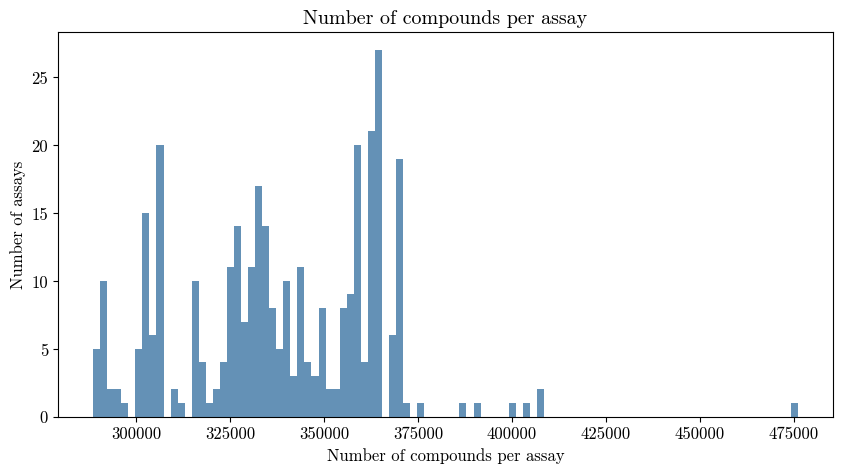

/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_87356/3429858893.py:26: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(primary_activity_columns_clean.values(), bins=100, color='#6491b6')


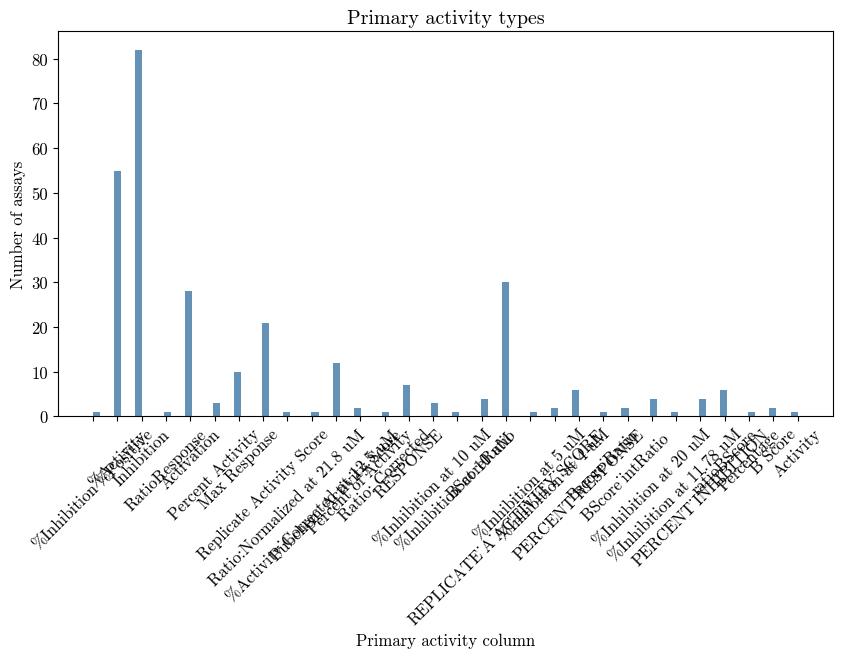

In [35]:
statistics(data_process)

In [324]:
data_process.compare_to_Helal()

-------------------------------------
# Helal valid AIDs: 243 | # my valid AIDs: 282
# overlap: 239
-------------------------------------


# Analysis

In [36]:
# Load the matrix
matrix_df = pd.read_csv(directory + '/final/activity_matrix_579_median.csv')
print(matrix_df.shape)
matrix_df.head()

(329242, 283)


,SMILES,651702,602399,588352,720702,624377,602429,588621,720700,720648,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...,2.922833,0.714176,0.004679,0.000000,0.000000,0.60705,0.302002,0.000000,0.000000,...,0.229999,-0.680031,-0.211341,0.0,0.000000,-1.192946,6.043618,-0.067503,0.0,-1.533463
1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...,1.377104,-0.119029,0.910770,0.017918,-0.420608,-0.10792,0.058752,0.271369,0.004557,...,-0.283869,0.000000,0.196160,0.0,-0.078143,-1.736599,0.241940,0.000000,0.0,-0.689406
2,CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C,0.815021,-0.317412,0.510359,0.140787,-1.196919,-0.43168,1.173470,-0.539600,-0.101783,...,0.000000,0.036254,-0.421591,0.0,0.242655,-0.224388,-0.439891,0.099853,0.0,-1.270743
3,C1=CC=C2C(=C1)C=C(C(=O)O2)N,2.782312,-0.357088,0.265901,-0.211821,-0.594960,-1.16014,-0.023630,0.222742,-0.050132,...,0.341117,-5.834661,0.633763,0.0,0.285154,0.491606,0.083091,-0.119580,0.0,-1.250247
4,C1COCCN1S(=O)(=O)C2=C(C=CC(=C2)C(=O)NC3=CC4=C(...,-0.674500,-0.634824,0.387155,0.056955,0.614686,1.71323,0.686650,0.067450,0.135204,...,0.068407,-2.291715,1.128342,0.0,-0.371523,-2.442917,0.444779,-0.543779,0.0,-1.056468


### Assay/Compound inactivity 

In [37]:
# check if there is any assay that has zero values across all compounds
pos_assays = torch.ones(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    
    if matrix_df[assay].any() != 0:
        pos_assays[i-1] = 0
    
# check if there is any compound that has zero values across all assays
pos_compounds = torch.ones(len(matrix_df))
for i, compound in enumerate(matrix_df['SMILES']):
    # print(matrix_df.iloc[i,1:])
    if matrix_df.iloc[i,1:].any() != 0:
        pos_compounds[i] = 0
        
if pos_assays.sum() > 0:
    print('Assays without activity: ', matrix_df.columns[1:][np.where(pos_assays.int().numpy()==1)])
else:
    print('Assays without activity: All assays have activity')
if pos_compounds.sum() > 0:
    print('Compounds without activity: ', matrix_df['SMILES'][np.where(pos_compounds.int().numpy()==1)])
else:
    print('Compounds without activity: All compounds have activity')

Assays without activity: All assays have activity
Compounds without activity: All compounds have activity


### Proportion of positive vs negative z-scores

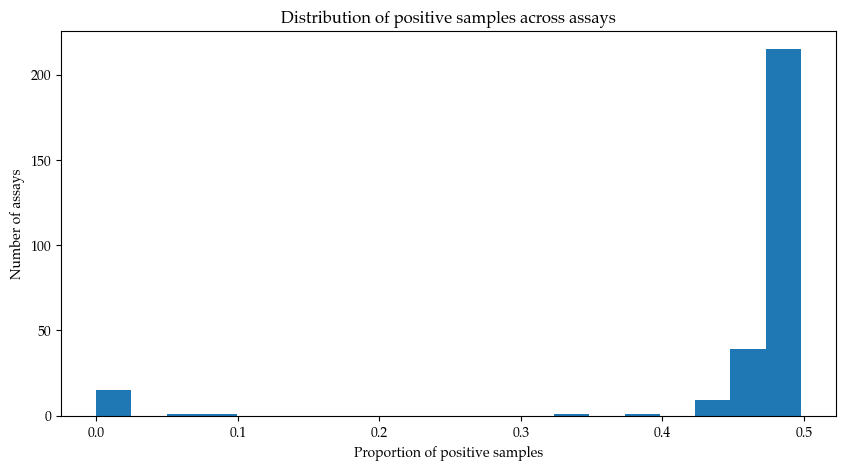

Assays with few positive samples: 
 ['2550' '2642' '2648' '488922' '488975' '488977' '588436' '588627'
 '588675' '588676' '602410' '623877' '2553' '463111' '463165' '651550'
 '588511']
Assays with balanced samples: 
 ['651702' '602399' '588352' '720702' '624377' '602429' '588621' '720700'
 '720648' '624416' '602162' '720704' '624204' '602229' '602163' '624415'
 '651699' '624038' '624414' '602438' '1053197' '624467' '624466' '652257'
 '1259415' '651560' '651602' '651819' '504651' '652054' '602449' '588492'
 '624267' '651821' '588493' '652051' '623870' '651957' '624304' '651572'
 '602274' '602248' '602261' '652126' '686940' '588489' '493056' '602244'
 '602250' '624268' '720543' '686964' '651999' '651958' '652048' '720582'
 '720596' '588850' '602247' '651636' '624040' '602440' '588458' '602281'
 '504660' '651800' '624125' '602123' '624127' '493084' '588664' '624126'
 '652067' '624169' '720509' '720508' '624168' '624354' '743126' '652017'
 '624037' '651725' '602396' '743269' '687014' '6517

In [328]:
# check proportion of positive and negative samples across each assay
pos_ratio = torch.zeros(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    # first make column binary
    y = np.where(matrix_df[assay].values>0, 1, 0)
    pos_ratio[i-1] = y.sum()/len(y)

#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(pos_ratio, bins=20)
plt.xlabel('Proportion of positive samples')
plt.ylabel('Number of assays')
plt.title('Distribution of positive samples across assays')
plt.show()

print('Assays with few positive samples: \n', matrix_df.columns[1:][torch.where(pos_ratio<0.2)].values)

balanced_assays = matrix_df.columns[1:][torch.where(pos_ratio>0.2)].values
print('Assays with balanced samples: \n', balanced_assays)


### Distribution of z-scores for a single assay

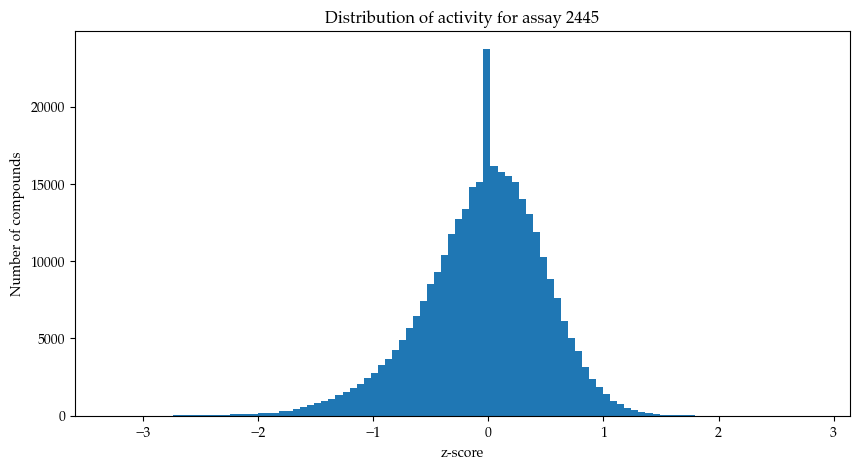

In [12]:
# show the distribution of values for any assay
assay = '504660'
assay = str(np.random.choice(data_process.valid_AIDs))
plt.figure(figsize=(10,5))
plt.hist(matrix_df[assay], bins=100)
plt.xlabel('z-score')
plt.ylabel('Number of compounds')
plt.title('Distribution of activity for assay '+assay)
# chagne range
#plt.ylim(-10, 10)
plt.show()

### Skew of z-scores across assays

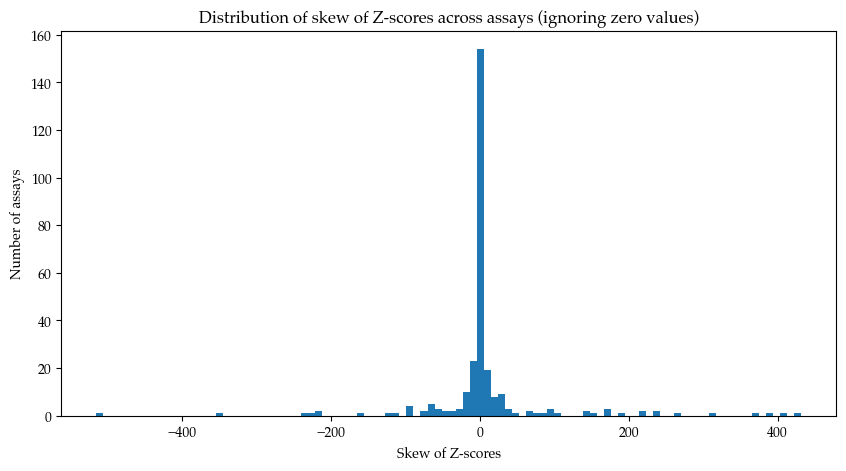

In [329]:
# calcualte the skew of the Z-scores for each assay, while excluding data fields with zero values
skew = []
for assay in matrix_df.columns[1:]:
    skew.append(matrix_df[assay][matrix_df[assay] != 0].skew())
#  A positive skewness indicates a tail on the right side of the distribution (more high positive values), 
# while a negative skewness indicates a tail on the left side (more small negative values). A skewness close to zero suggests a relatively symmetrical distribution.

# plot the skew of the Z-scores for each assay
plt.figure(figsize=(10,5))
plt.hist(skew, bins=100)
plt.xlabel('Skew of Z-scores')
plt.ylabel('Number of assays')
plt.title('Distribution of skew of Z-scores across assays (ignoring zero values)')
plt.show()

### Observations
A number of assays have mainly positive z-scores or mainly negative z-scores.
It seems that all of those have many compoounds with low negative scores and very few with very high positive scores. This indicates that few compounds are strong outliers on one side and shift the mean such that almost all compounds get a negative z-score. The effect of one strong outlier washes out the distribution for all other compound -> is this a valid outlier or noise?

### Stats on Z-scores for each assay

In [330]:
# check the mean and std of the Z-scores for each assay
matrix_df.iloc[:, 1:].describe()


,651702,602399,588352,720702,624377,602429,588621,720700,720648,624416,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
count,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,...,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000,329242.000000
mean,0.424042,0.166287,-0.158856,-0.015479,-0.002360,-0.188648,-0.000937,-2.167488,-1.309813,-0.001110,...,0.028032,-0.174191,-0.050863,-0.071192,0.037244,-0.082666,-0.036410,-0.065053,0.239525,0.531347
std,2.673158,1.141960,0.821039,0.536412,0.512554,1.707065,0.891722,13.020257,12.461774,1.002324,...,0.604976,2.632165,0.801377,1.929207,0.706166,0.876207,2.719785,0.697776,2.638474,5.470552
min,-17.284063,-36.780087,-31.965841,-5.428637,-28.250732,-412.820984,-175.685684,-237.467911,-367.569092,-122.472847,...,-6.078332,-48.801018,-16.116966,-67.461052,-3.042105,-10.350370,-140.205582,-51.757000,0.000000,-12.310556
25%,-0.618292,-0.317412,-0.381989,-0.343010,-0.331523,-0.364230,-0.347996,-0.368622,-0.344846,-0.337250,...,-0.286528,0.000000,-0.349987,-0.286377,-0.316686,-0.287115,-0.347025,-0.320009,0.000000,-0.309301
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.758812,0.337250,0.303330,0.319972,0.327705,0.310270,0.322797,0.301172,0.317501,0.323624,...,0.292757,0.000000,0.315945,0.286948,0.329024,0.289922,0.317699,0.284430,0.000000,0.368925
max,33.191021,20.294516,4.423823,11.813349,14.806547,24.153845,12.656386,12.482956,8.013485,32.692810,...,8.646088,62.467197,5.239542,260.658813,16.101631,29.731577,187.980225,4.501803,50.587498,374.694061


### Assays with PUBCHEM ACTIVITY SCORE as primary activity

In [332]:
# count the number of assays for which the primary activity column is 'PUBCHEM_ACTIVITY_SCORE'
count = 0
for AID, column in data_process.primary_activity_columns.items():
    if column == 'PUBCHEM_ACTIVITY_SCORE':
        count += 1
print('Number of assays for which the primary activity column is PUBCHEM_ACTIVITY_SCORE:', count, 'out of', len(data_process.primary_activity_columns))

Number of assays for which the primary activity column is PUBCHEM_ACTIVITY_SCORE: 12 out of 294


# Further filters
### Filter promiscuous compounds

In [62]:
# filter promiscuous compounds
z_threshold = 3 # defines the threshold for what is a hit
hit_threshold = 0.05 # defines the threshold for what is a promiscuous compound: i.e., in what fraction of assays does it appear as a hit
data_process.filter_promiscuous_compounds(z_threshold, hit_threshold)

Filtering promiscuous compounds...
No. of promiscuous compounds filtered: 5050 (2% of compounds)
SUCCESS


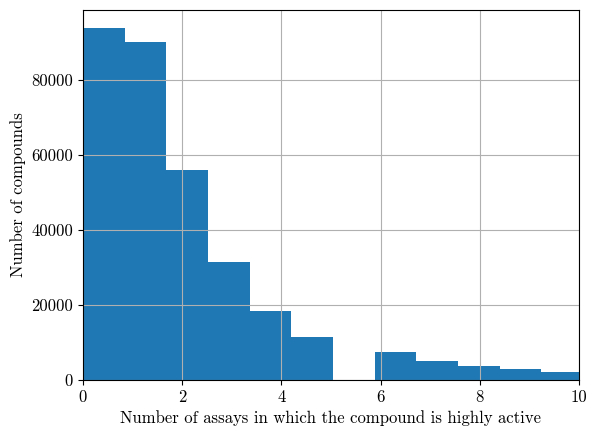

/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/2280323620.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(num_tested_final.values(), bins=50, color='#6491b6')


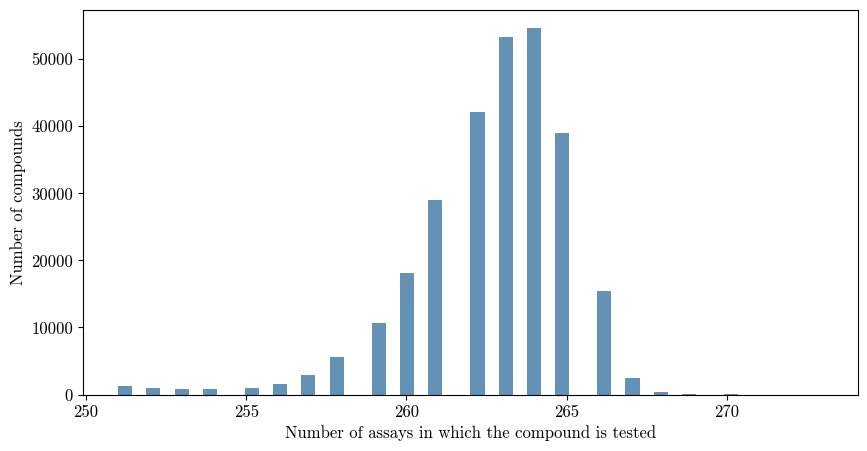

In [55]:
data_process.num_active.hist(bins=100)
plt.xlabel('Number of assays in which the compound is highly active')
plt.ylabel('Number of compounds')
plt.xlim(0, 10)
plt.show()

plt.figure(figsize=(10,5))
# remove compounds with below cut_off_assays assays
num_tested_final = {k: v for k, v in data_process.num_tested.items() if v > data_process.cut_off_assays}

plt.hist(num_tested_final.values(), bins=50, color='#6491b6')
plt.xlabel('Number of assays in which the compound is tested')
plt.ylabel('Number of compounds')
# remove grid
plt.grid(False)
#plt.savefig('Figures/num_tested.png', dpi=300)
plt.show()


### Filter inactive compounds

In [64]:
data_process.filter_inactive_compounds(z_threshold=0.5)

Filtering inactive compounds...
No. of inactive compounds filtered: 0 (0.0 % of compounds)
No. of compounds tested in less than 70% assays filtered: 4139 (1.28 % of compounds)
SUCCESS


### Binarize assay activity

In [65]:
matrix_df_filtered = pd.read_csv(directory + '/final/activity_matrix_filtered_579_median.csv')
print('Filtered matrix shape:', matrix_df_filtered.shape)
matrix_df_filtered.head()

activity_threshold = 2
matrix_df_binary = data_process.binarize_matrix(matrix_df_filtered, activity_threshold = activity_threshold, save=True)
print('Binary matrix shape:', matrix_df_binary.shape)
matrix_df_binary.head()


Filtered matrix shape: (320016, 283)


,SMILES,651702,602399,588352,720702,624377,602429,588621,720700,720648,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...,2.922833,0.714176,0.004679,0.000000,0.000000,0.60705,0.302002,0.000000,0.000000,...,0.229999,-0.680031,-0.211341,0.0,0.000000,-1.192946,6.043618,-0.067503,0.0,-1.533463
1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...,1.377104,-0.119029,0.910770,0.017918,-0.420608,-0.10792,0.058752,0.271369,0.004557,...,-0.283869,0.000000,0.196160,0.0,-0.078143,-1.736599,0.241940,0.000000,0.0,-0.689406
2,CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C,0.815021,-0.317412,0.510359,0.140787,-1.196919,-0.43168,1.173470,-0.539600,-0.101783,...,0.000000,0.036254,-0.421591,0.0,0.242655,-0.224388,-0.439891,0.099853,0.0,-1.270743
3,C1=CC=C2C(=C1)C=C(C(=O)O2)N,2.782312,-0.357088,0.265901,-0.211821,-0.594960,-1.16014,-0.023630,0.222742,-0.050132,...,0.341117,-5.834661,0.633763,0.0,0.285154,0.491606,0.083091,-0.119580,0.0,-1.250247
4,CCC1=C(N2C(=NC=N2)N=C1C)N3CCCC(C3)C(=O)NC4=CC=...,3.063354,-0.138868,0.273699,0.185583,1.007932,0.41819,0.892429,0.177252,0.121532,...,-1.299598,0.000000,0.245514,0.0,0.777320,0.000000,0.241940,0.000000,0.0,-0.799338


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/1840924048.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


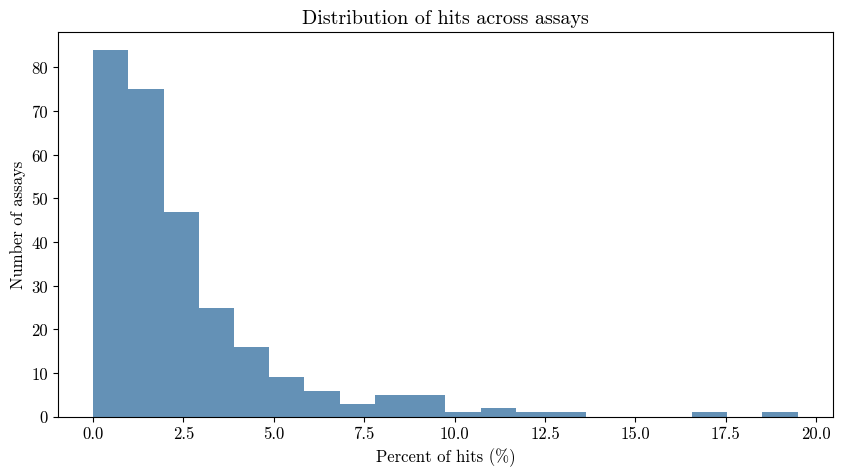

In [70]:
# sum matrix_df across rows
hit_ratio = matrix_df_binary.iloc[:,1:].sum(axis=0)/matrix_df_binary.shape[0]

#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(100*hit_ratio, bins=20, color='#6491b6')
plt.xlabel('Percent of hits (%)')
plt.ylabel('Number of assays')
plt.title(f'Distribution of hits across assays')
plt.savefig('Figures/hit_ratio_2.png', dpi=300)
plt.show()

#print('Assays with few hits (<1%): \n', matrix_df.columns[1:][torch.where(torch.tensor(hit_ratio)<0.01)].values)

# balanced_assays = matrix_df.columns[1:][torch.where(pos_ratio>0.2)].values
# print('Assays with balanced samples: \n', balanced_assays)


### Hit ratio vs activation threshold

/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/608347353.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


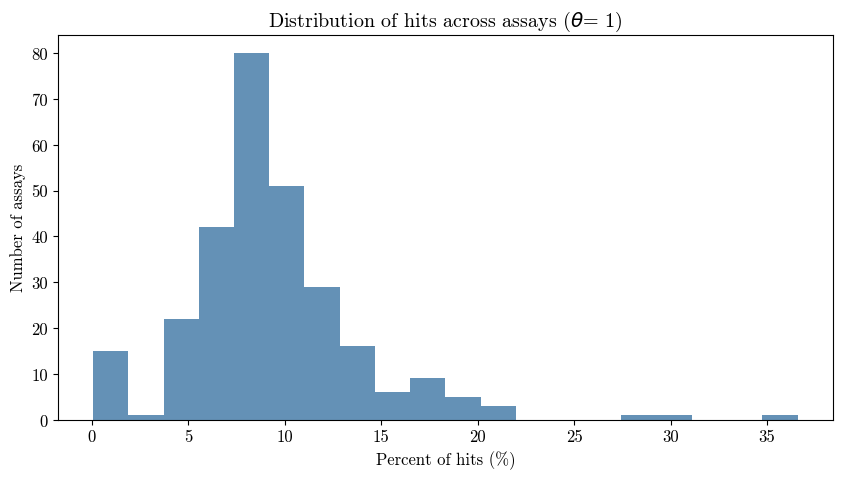

Hit ratio stats:
count    282.000000
mean       0.093308
std        0.045237
min        0.000700
25%        0.070236
50%        0.085968
75%        0.110762
max        0.365857
dtype: float64


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/608347353.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


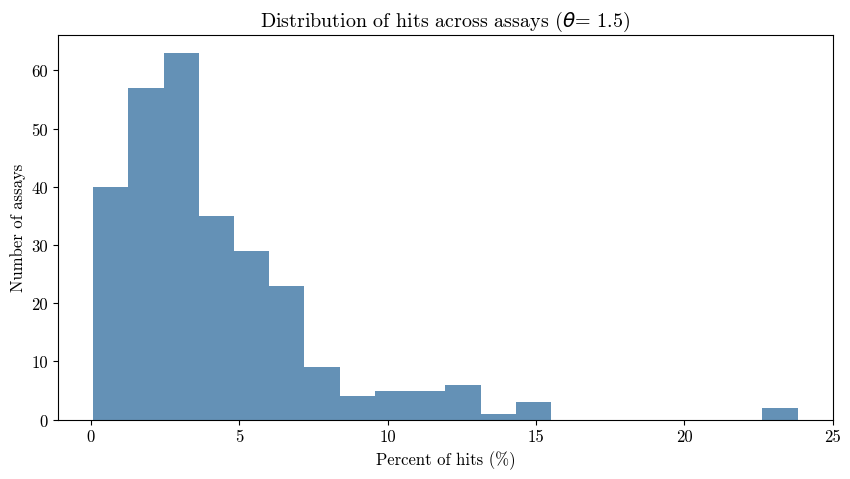

Hit ratio stats:
count    282.000000
mean       0.041736
std        0.034306
min        0.000700
25%        0.019682
50%        0.031958
75%        0.054793
max        0.238201
dtype: float64


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/608347353.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


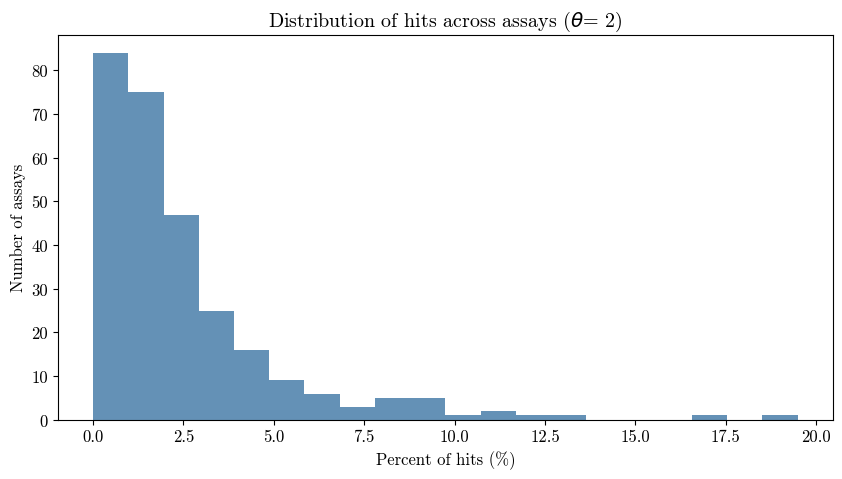

Hit ratio stats:
count    282.000000
mean       0.025088
std        0.027255
min        0.000031
25%        0.007878
50%        0.017244
75%        0.031010
max        0.194828
dtype: float64


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/608347353.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


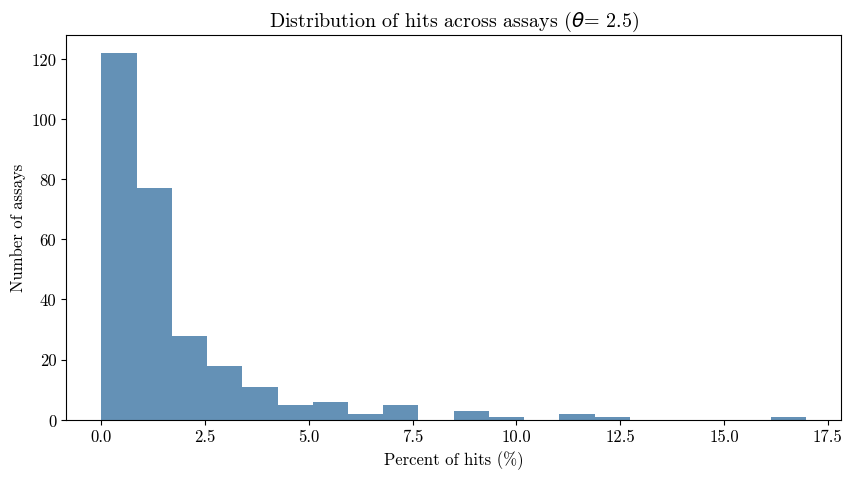

Hit ratio stats:
count    282.000000
mean       0.017290
std        0.022455
min        0.000003
25%        0.004018
50%        0.010151
75%        0.019934
max        0.169773
dtype: float64


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/608347353.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(100*hit_ratio, bins=20, color='#6491b6')


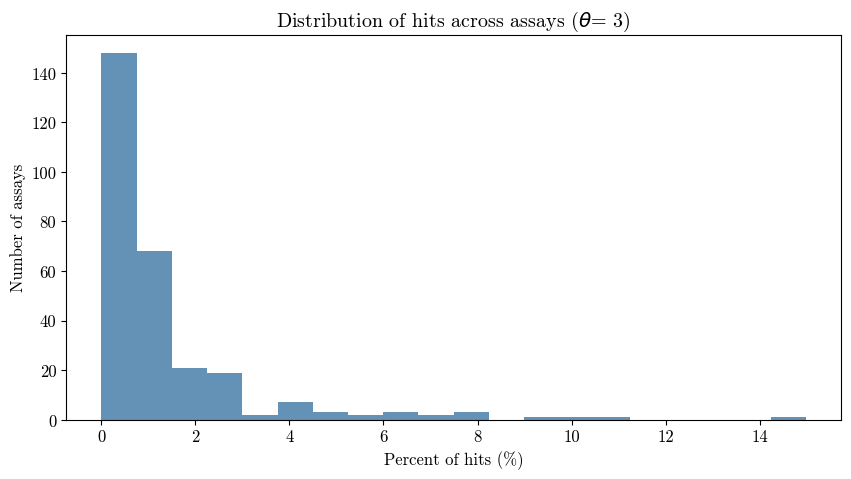

Hit ratio stats:
count    282.000000
mean       0.012887
std        0.019102
min        0.000000
25%        0.002099
50%        0.006993
75%        0.014139
max        0.149877
dtype: float64


In [71]:
for idx, activity_threshold in enumerate([1, 1.5, 2, 2.5, 3]):
    # create binary matrix
    matrix_df_binary = data_process.binarize_matrix(matrix_df_filtered, activity_threshold = activity_threshold, save=False)

    # sum matrix_df across rows
    hit_ratio = matrix_df_binary.iloc[:,1:].sum(axis=0)/matrix_df_binary.shape[0]

    #plot hit_ratio in subplot with figsize
    plt.figure(figsize=(10,5))
    plt.hist(100*hit_ratio, bins=20, color='#6491b6')

    #plt.figure(figsize=(10,5))
    #plt.hist(hit_ratio, bins=20)
    plt.xlabel('Percent of hits (%)')
    plt.ylabel('Number of assays')
    plt.title(r'Distribution of hits across assays ($\theta$' + f'= {activity_threshold})')
    plt.savefig('Figures/hit_ratio_'+str(activity_threshold)+'.png', dpi=300)
    plt.show()
    print('Hit ratio stats:')
    print(hit_ratio.describe())


### Remove assays that are too active and too inactive

In [72]:
data_process.activity_threshold = 2
data_process.filter_active_and_inactive_assays(overactive_assay_std_multiply=3, inactive_assay_threshold=0.0005)

Filtering overly active and inactive assays... 

# of overly active assays filtered:  7
 Assays: 
 ['651702' '602440' '624352' '588405' '540275' '588436' '2314']

# of overly inactive assays filtered:  4
 Assays: 
 ['602247' '720508' '504700' '504707']

SUCCESS


filtered out 9 assays: 7 overly active, 4 inactive

# Final matrix

In [73]:
# load filtered matrix
matrix_df_binary = pd.read_csv(directory + '/final/activity_matrix_579_median_binary_at2.csv')
print('Matrix shape: ', matrix_df_binary.shape)
matrix_df_binary.head()

Matrix shape:  (320016, 272)


,SMILES,602399,588352,720702,624377,602429,588621,720700,720648,624416,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1=CC=C2C(=C1)C=C(C(=O)O2)N,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,CCC1=C(N2C(=NC=N2)N=C1C)N3CCCC(C3)C(=O)NC4=CC=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/2897624460.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(hit_ratio, bins=20, color='#6491b6')


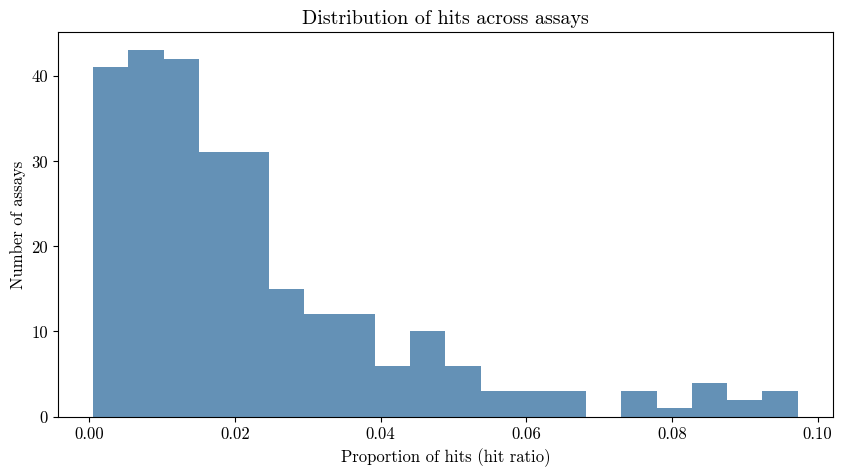

Assays with few hits (<1%): 
 ['720702' '624377' '588621' '624038' '651560' '651602' '504651' '624267'
 '651957' '624304' '651572' '602244' '602250' '686964' '624040' '651800'
 '624125' '602123' '588664' '624126' '624169' '720509' '652017' '743269'
 '651718' '602141' '2380' '2550' '2642' '2648' '2825' '435030' '449728'
 '463079' '463141' '463210' '485347' '488965' '488975' '488977' '489030'
 '489031' '492972' '493008' '493087' '493098' '493160' '493187' '493244'
 '504406' '504523' '504577' '504621' '504634' '504692' '504734' '540267'
 '540295' '588335' '588627' '588675' '588676' '588819' '602410' '623877'
 '1511' '1554' '1875' '1950' '1987' '2234' '2300' '2445' '2553' '2690'
 '434962' '434989' '463111' '463165' '463190' '463212' '485272' '651719'
 '588511']


In [74]:
activity_threshold = 2
# sum matrix_df across rows
hit_ratio = matrix_df_binary.iloc[:,1:].sum(axis=0)/matrix_df_binary.shape[0]

#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(hit_ratio, bins=20, color='#6491b6')
plt.xlabel('Proportion of hits (hit ratio)')
plt.ylabel('Number of assays')
plt.title(f'Distribution of hits across assays')
plt.savefig('Figures/hit_ratio_final.png', dpi=300)
plt.show()

print('Assays with few hits (<1%): \n', matrix_df_binary.columns[1:][torch.where(torch.tensor(hit_ratio)<0.01)].values)

# balanced_assays = matrix_df.columns[1:][torch.where(pos_ratio>0.2)].values
# print('Assays with balanced samples: \n', balanced_assays)


# Outlier detection
Find potential outliers, then find true outliers, then change their activity in the binary activity matrix to 0

In [75]:
matrix_df_filtered = pd.read_csv(directory + '/final/activity_matrix_filtered_579_median.csv')
print('Filtered matrix shape:', matrix_df_filtered.shape)
matrix_df_filtered.head()

Filtered matrix shape: (320016, 283)


,SMILES,651702,602399,588352,720702,624377,602429,588621,720700,720648,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...,2.922833,0.714176,0.004679,0.000000,0.000000,0.60705,0.302002,0.000000,0.000000,...,0.229999,-0.680031,-0.211341,0.0,0.000000,-1.192946,6.043618,-0.067503,0.0,-1.533463
1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...,1.377104,-0.119029,0.910770,0.017918,-0.420608,-0.10792,0.058752,0.271369,0.004557,...,-0.283869,0.000000,0.196160,0.0,-0.078143,-1.736599,0.241940,0.000000,0.0,-0.689406
2,CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C,0.815021,-0.317412,0.510359,0.140787,-1.196919,-0.43168,1.173470,-0.539600,-0.101783,...,0.000000,0.036254,-0.421591,0.0,0.242655,-0.224388,-0.439891,0.099853,0.0,-1.270743
3,C1=CC=C2C(=C1)C=C(C(=O)O2)N,2.782312,-0.357088,0.265901,-0.211821,-0.594960,-1.16014,-0.023630,0.222742,-0.050132,...,0.341117,-5.834661,0.633763,0.0,0.285154,0.491606,0.083091,-0.119580,0.0,-1.250247
4,CCC1=C(N2C(=NC=N2)N=C1C)N3CCCC(C3)C(=O)NC4=CC=...,3.063354,-0.138868,0.273699,0.185583,1.007932,0.41819,0.892429,0.177252,0.121532,...,-1.299598,0.000000,0.245514,0.0,0.777320,0.000000,0.241940,0.000000,0.0,-0.799338


### Find the units of the primary activity column for each AID

In [76]:
# find the units of the primary activity column for each AID
def check_for_percent(lst):
    for item in lst:
        if type(item) == float or type(item) == int:
            continue
        if 'percent' in item.lower() or '%' in item:
            return True

    return False
    
units = {}
for AID in data_process.valid_AIDs:
    
    # import csv file from path
    path = directory + f'/AID_{AID}.csv'
    df = pd.read_csv(path, sep=',', header=0, dtype={'PUBCHEM_CID': 'Int64', 'PUBCHEM_EXT_DATASOURCE_SMILES': str, 'PUBCHEM_ACTIVITY_OUTCOME': str,'Compound QC':str}, low_memory=False)
    # drop the first column
    df = df.drop(df.columns[0], axis=1)
    # drop rows with NaN values in the 'PUBCHEM_SID' column
    #df = df.dropna(subset=['PUBCHEM_CID'])
    # reset the index
    df = df.reset_index(drop=True)
    
    primary_activity = data_process.primary_activity_columns[int(AID)]
    # look into first 3 rows of primary activity column for unit
    search = df[primary_activity].values.tolist()[:3]

    # Check if the list contains any mention of percent
    percent = check_for_percent(search)
    if percent:
        units[AID] = 'percent'
        
    else:
        units[AID] = 'none'


In [77]:
# calculate thenumber of assays with each unit
units_count = {}
for unit in set(units.values()):
    units_count[unit] = list(units.values()).count(unit)

print('Number of assays with each unit:')
print(units_count)

Number of assays with each unit:
{'none': 17, 'percent': 265}


### Find outliers and set their activity in binary activity matrix to zero

In [78]:
# load binary matrix
matrix_df_binary = pd.read_csv(directory + '/final/activity_matrix_579_median_binary_at2.csv')
# remove columns from matrix_df_filtered that are not in matrix_df_binary
matrix_df_filtered = matrix_df_filtered[matrix_df_binary.columns]
# find potential outliers (z-score > 10) in each assay
matrix_df_out = data_process.binarize_matrix(matrix_df_filtered, activity_threshold=10, save=False)
# ratio of potential outliers in each assay
out_ratio = matrix_df_out.iloc[:,1:].sum(axis=0)/matrix_df_out.shape[0]

In [79]:
num_true_outliers = {}
true_outliers_ratio = {}
for AID in matrix_df_binary.columns[1:]:
    # find the SMILES compounds that are pontetial outliers (that have value 1 in matrix_df_out)
    outliers_idx = np.where(matrix_df_out[AID] == 1)[0]
    outliers_smiles = matrix_df_out['SMILES'][outliers_idx]

    # find primary activity values for each compound in outlier_smiles in original dataset
    # load raw bioassay data
    assay_df = data_process.load_bioassay_data(AID)
    primary_activity = data_process.primary_activity_columns[int(AID)]
    # choose primary activity column and SMILES column
    assay_df = assay_df[['PUBCHEM_EXT_DATASOURCE_SMILES', primary_activity]]
    # Filter rows based on outliers_smiles array
    filtered_df = assay_df[assay_df['PUBCHEM_EXT_DATASOURCE_SMILES'].isin(outliers_smiles)]
    # turn primary activity into a float
    #filtered_df[primary_activity] = filtered_df[primary_activity].astype(float)

    # select true outliers from potential outliers
    if units[int(AID)] == 'percent':
        # find smiles with values greater than 1000
        true_out_idx = filtered_df[primary_activity].astype(float) > 1000

    else:
        # find smiles with values greater than BScore of 100
        true_out_idx = filtered_df[primary_activity].astype(float) > 100

    true_out_smiles = filtered_df.loc[true_out_idx]['PUBCHEM_EXT_DATASOURCE_SMILES'].tolist()

    num_true_outliers[AID] = len(true_out_smiles)
    if len(outliers_smiles) == 0:
        true_outliers_ratio[AID] = 0
    else:
        true_outliers_ratio[AID] = round(len(true_out_smiles) / len(outliers_smiles), 4)

    # change the activity of true outliers to 0 in binary matrix
    matrix_df_binary.loc[matrix_df_binary['SMILES'].isin(true_out_smiles), AID] = 0

# save matrix_df_binary to csv
matrix_df_binary.to_csv(directory + '/final/activity_matrix_579_median_binary_at2_no_out.csv', index=False)


### Visualize hits

/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/3291272955.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(out_ratio*100, bins=100)


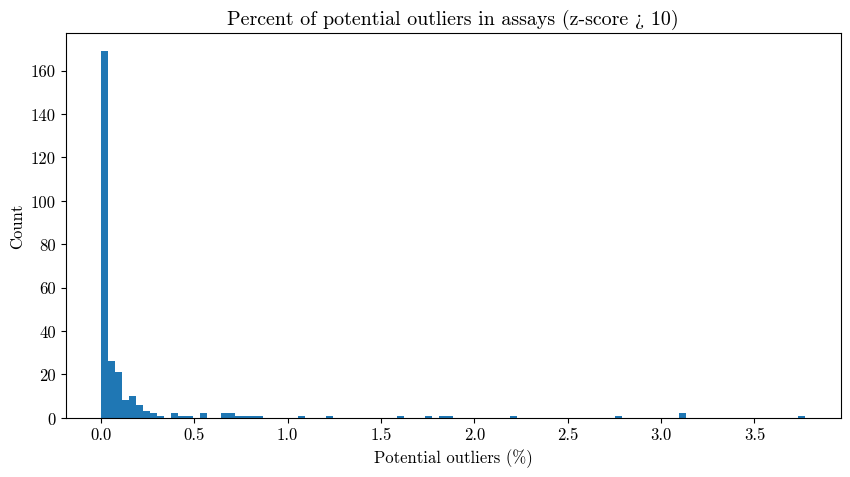

/var/folders/r6/b5w3tj2n6b31b6g5n19btpj80000gn/T/ipykernel_92507/3291272955.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(out_ratio*100*list(true_outliers_ratio.values()), bins=100)


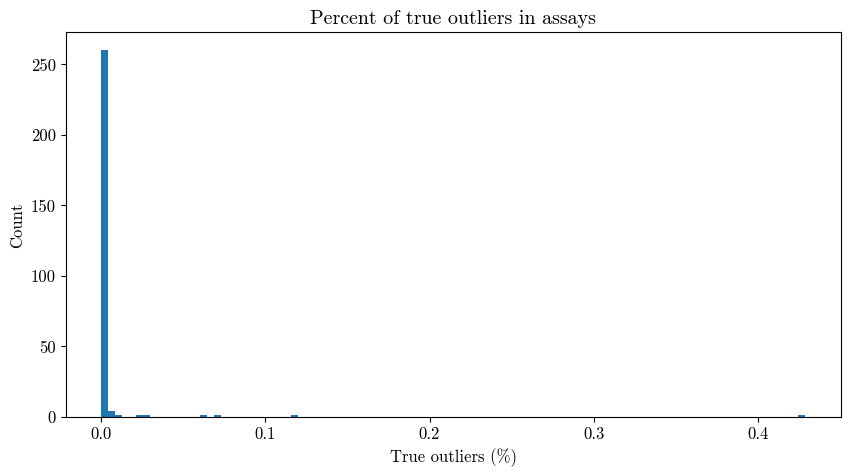

In [80]:
# visualize histogram of out_ratio
plt.figure(figsize=(10, 5))
plt.hist(out_ratio*100, bins=100)
plt.xlabel('Potential outliers (%)')
plt.ylabel('Count')
plt.title('Percent of potential outliers in assays (z-score > 10)')
plt.show()

# visualize histogram of true_outliers_ratio
plt.figure(figsize=(10, 5))
plt.hist(out_ratio*100*list(true_outliers_ratio.values()), bins=100)
plt.xlabel('True outliers (%)')
plt.ylabel('Count')
plt.title('Percent of true outliers in assays')
plt.show()

In [83]:
# find how many times is num_true_outliers is zero
print('Zero outliers in', (torch.tensor(list(num_true_outliers.values())) == 0).sum().item(), 'assays')
# find the total sum of outliers
print('Total number of outliers:', torch.tensor(list(num_true_outliers.values())).sum().item())

Zero outliers in 244 assays
Total number of outliers: 2532


In [84]:
#true_outliers_ratio.values()
# find the average of the non-zero values
print('Avg. percent of outliers in assays with outliers:',torch.tensor(list(out_ratio*100*list(true_outliers_ratio.values())))[torch.tensor(list(true_outliers_ratio.values())) != 0].mean(),'%')


Avg. percent of outliers in assays with outliers: tensor(0.0293) %


# Correlations between assays
check correlation between assays → aka check overlap of hits

In [6]:
# load filtered matrix
matrix_df_binary = pd.read_csv(directory + '/final/activity_matrix_579_median_binary_at2_no_out.csv')
print('Matrix shape: ', matrix_df_binary.shape)
matrix_df_binary.head()

Matrix shape:  (320016, 272)


,SMILES,602399,588352,720702,624377,602429,588621,720700,720648,624416,...,485344,651550,588674,743397,651719,651724,1259313,1259400,588511,588726
0,CC1=C(C(=NS1)S(=O)(=O)/C(=N/NC2=CC=CC(=C2)C(F)...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCCC4=CC=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC1=NN=C(N1/N=C\C2=CC=C(C=C2)C(=O)OC)C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1=CC=C2C(=C1)C=C(C(=O)O2)N,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,CCC1=C(N2C(=NC=N2)N=C1C)N3CCCC(C3)C(=O)NC4=CC=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# for each assay, find the smiles that are active
hits = {}
for AID in matrix_df_binary.columns[1:]:
    hits[AID] = set(matrix_df_binary['SMILES'][matrix_df_binary[AID]==1].values)

In [8]:
# create overlap matrix
corr_matrix = np.zeros((len(hits), len(hits)))
for i, AID_i in enumerate(hits.keys()):
    for j, AID_j in enumerate(hits.keys()):
        corr_matrix[i,j] = len(hits[AID_i].intersection(hits[AID_j]))/len(hits[AID_i])

In [9]:
# find the subset of the correlation matrix for assays ['2797', '2796', '1979', '602248', '1910', '602274', '720582', '1259313', '624204', '652039']
AIDs = ['2797', '2796', '1979', '602248', '1910', '602274', '720582', '1259313', '624204', '652039']
index = []
for AID in AIDs:
    index.append(np.where(matrix_df_binary.columns[1:] == AID)[0][0])
index = np.array(index)
corr_matrix_subset = corr_matrix[index][:,index]
# set diagonal to zero
np.fill_diagonal(corr_matrix_subset, 0)

/Users/david/opt/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/Users/david/opt/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


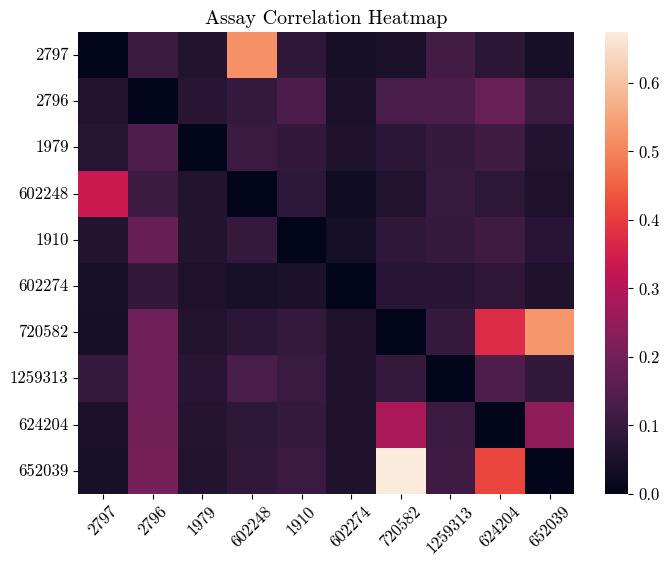

In [10]:
# visualize corr_matrix as a heatmap
import seaborn as sns

plt.figure(figsize=(8,6))
heatmap = sns.heatmap(corr_matrix_subset)
# add the column names as labels
heatmap.set_xticklabels(AIDs)
heatmap.set_yticklabels(AIDs)
# rotate the labels
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Assay Correlation Heatmap')
plt.savefig('Figures/assay_correlation_heatmap.png', dpi=300)
plt.show()

In [16]:
# change correlation matrix to dataframe with AIDs as columns and rows
corr_df = pd.DataFrame(corr_matrix, columns=matrix_df_binary.columns[1:], index=matrix_df_binary.columns[1:])
corr_df.head()
#save correlation matrix to csv
corr_df.to_csv(directory + '/final/assay_correlation_matrix.csv', index=True)

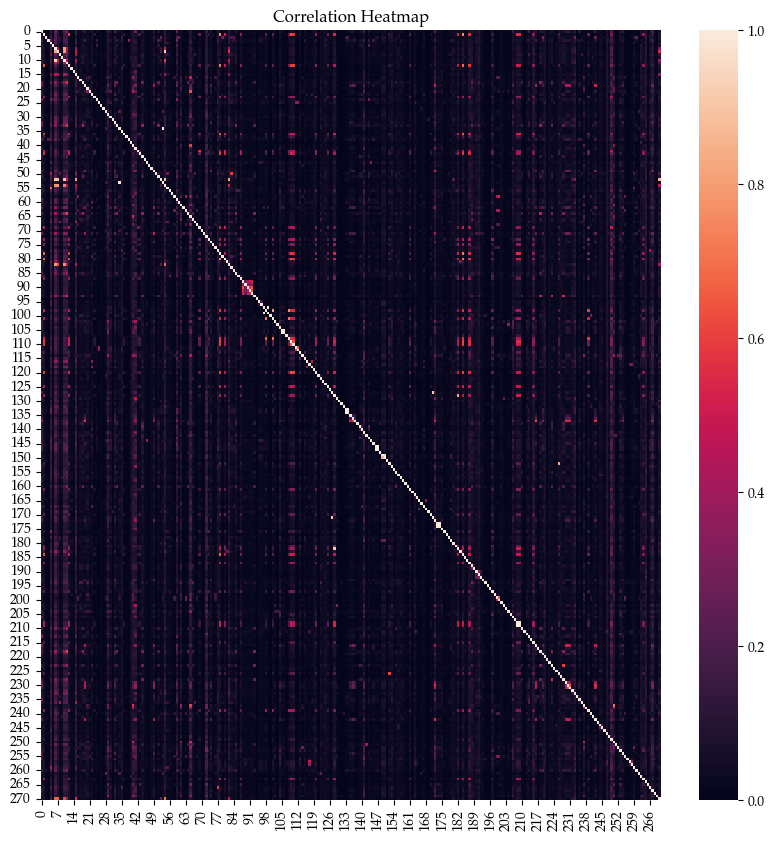

In [39]:
# visualize corr_matrix as a heatmap
import seaborn as sns

plt.figure(figsize=(10,10))
heatmap = sns.heatmap(corr_matrix)
plt.title('Assay Correlation Heatmap')
plt.show()